In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
from read_db.CH import Getch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(font_scale=1.2, rc={'figure.figsize':(12,8)})

### Линеаризация

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

- Посчитать CTR в контрольной группе
- Посчитать поюзерную метрику в обеих группах 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
- После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

In [26]:
df = Getch("""
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220520.feed_actions 
WHERE toDate(time) between '2022-04-24' and '2022-04-30'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
""").df

In [27]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [28]:
Control_CRT = sum(df[df['exp_group'] == 1]['likes']) / sum(df[df['exp_group'] == 1]['views'])

In [29]:
Control_CRT

0.20802680490126244

In [30]:
def linearizaed_likes(likes, views, CTRcontrol):
    return likes - (views * CTRcontrol)

In [31]:
exp_group_1 = df[df['exp_group'] == 1].apply(lambda x: linearizaed_likes(x['likes'], x['views'], Control_CRT), axis=1)
exp_group_2 = df[df['exp_group'] == 2].apply(lambda x: linearizaed_likes(x['likes'], x['views'], Control_CRT), axis=1)

In [32]:
exp_group_1.mean(), exp_group_2.mean()

(-4.3144374867068293e-16, -0.6592771236485203)

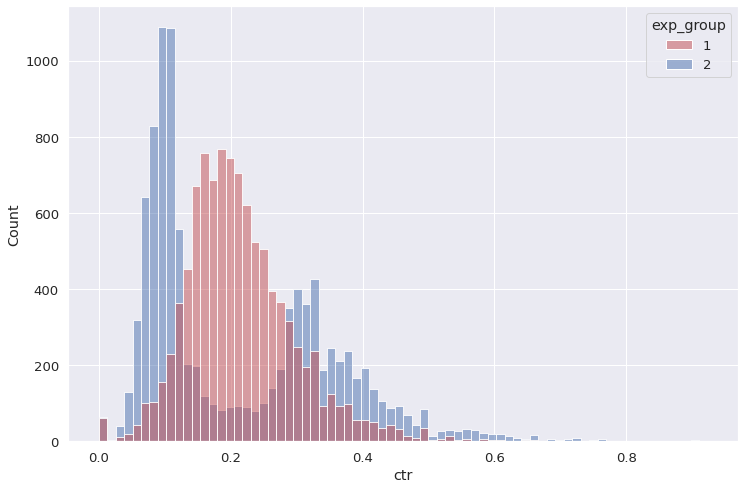

In [33]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

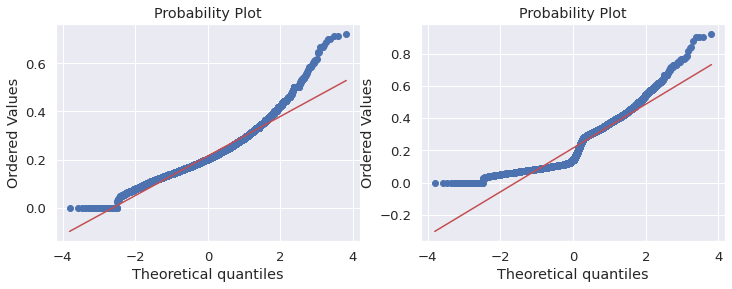

In [37]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
stats.probplot(df[df['exp_group']==1].ctr, dist="norm", plot=pylab)

plt.subplot(1,2,2)
stats.probplot(df[df['exp_group']==2].ctr, dist="norm", plot=pylab)
pylab.show()

<AxesSubplot:ylabel='Count'>

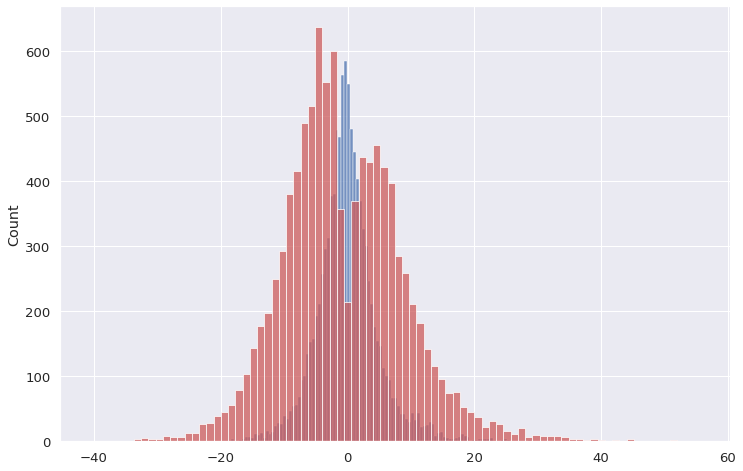

In [34]:
sns.histplot(exp_group_1)
sns.histplot(exp_group_2, color = 'indianred')

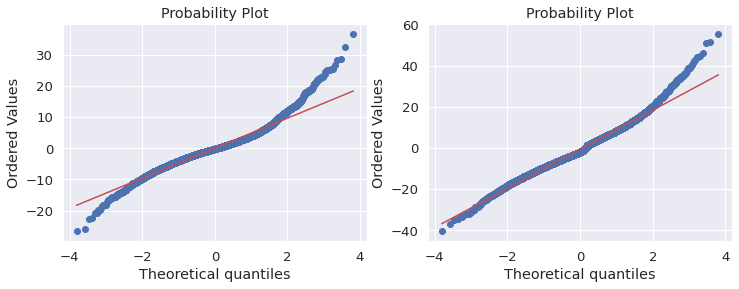

In [36]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
stats.probplot(exp_group_1, dist="norm", plot=pylab)

plt.subplot(1,2,2)
stats.probplot(exp_group_2, dist="norm", plot=pylab)
pylab.show()

Линеаризация приближает распределение к нормальному

In [38]:
stats.ttest_ind(a=exp_group_1, 
                b=exp_group_2, 
                equal_var=False)

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

По сравнению с непреобразованном распределении в линеаризированом выше чувствительность это видно на графике  

##### Все тоже самое, но только группы 0 и 3

In [39]:
df = Getch("""
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220520.feed_actions 
WHERE toDate(time) between '2022-04-24' and '2022-04-30'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
""").df

In [40]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


In [41]:
Control_CRT = sum(df[df['exp_group'] == 0]['likes']) / sum(df[df['exp_group'] == 0]['views'])

In [42]:
def linearizaed_likes(likes, views, CTRcontrol):
    return likes - (views * CTRcontrol)

In [43]:
group_0 = df[df['exp_group'] == 0].apply(lambda x: linearizaed_likes(x['likes'], x['views'], Control_CRT), axis=1)
group_3 = df[df['exp_group'] == 3].apply(lambda x: linearizaed_likes(x['likes'], x['views'], Control_CRT), axis=1)

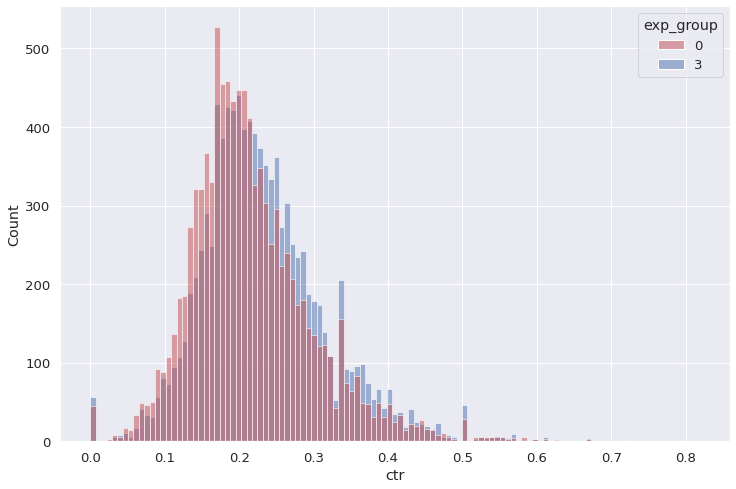

In [44]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

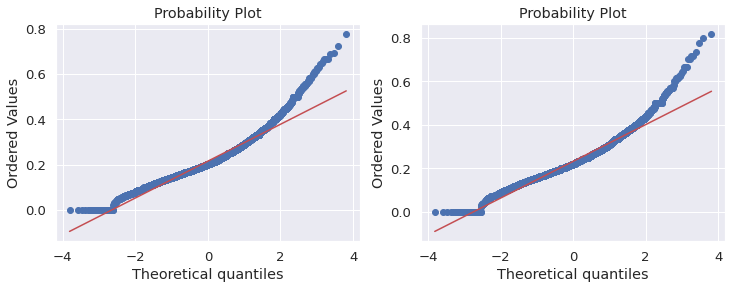

In [45]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
stats.probplot(df[df['exp_group']==0].ctr, dist="norm", plot=pylab)

plt.subplot(1,2,2)
stats.probplot(df[df['exp_group']==3].ctr, dist="norm", plot=pylab)
pylab.show()

<AxesSubplot:ylabel='Count'>

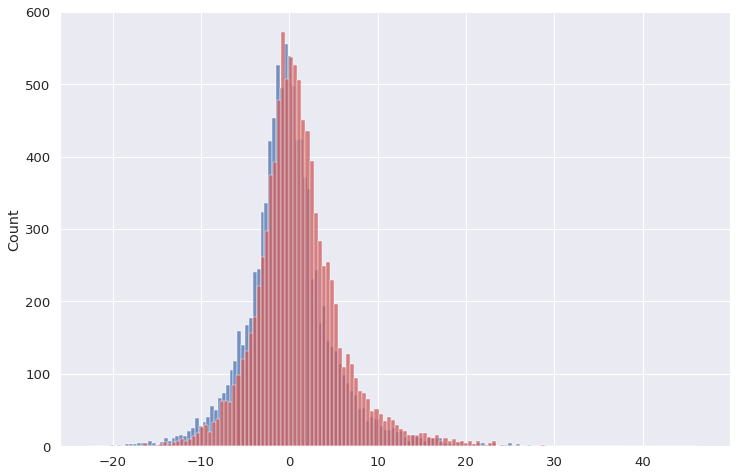

In [48]:
sns.histplot(group_0)
sns.histplot(group_3, color = 'indianred')

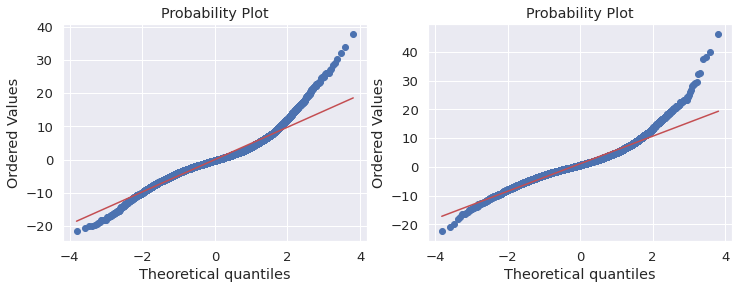

In [49]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
stats.probplot(group_0, dist="norm", plot=pylab)

plt.subplot(1,2,2)
stats.probplot(group_3, dist="norm", plot=pylab)
pylab.show()

In [50]:
stats.ttest_ind(a=group_0, 
                b=group_3, 
                equal_var=False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.491424947968532e-52)

**Вывод**  

Группа 1 и 2  
 - линеаризация помогла приблизить распределения 1 и 2 группы к нормальному, повысить чувствительность и провести t-test 
 - p-value стал меньше
 
Группа 0 и 3  
 - линеаризация помогла повысить чувствительность
 - распределения были ближе к нормальному, такого значительно эффекта как в 1 и 2 группе не обнаружено
 - p-value стал меньше